<a href="https://colab.research.google.com/github/syedshubha/PulseSCQ/blob/main/QPT_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet qutip qutip-qip qiskit qiskit-aer pylatexenc &> /dev/null

In [25]:
import qutip as qt
from qutip import Qobj
from qiskit import QuantumCircuit, QuantumRegister
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate, gate_sequence_product
from qiskit.quantum_info import Operator, process_fidelity, Choi, Operator, DensityMatrix, Kraus, SuperOp, Pauli


import numpy as np
from scipy.linalg import polar, logm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd

#No Pulse Attack

In [3]:
theta_vals = np.linspace(0, np.pi, 100)

theory = []
for theta in theta_vals:
    # Prepare input state: cos(θ)|0⟩ + sin(θ)|1⟩
    state_init = (np.cos(theta) * qt.basis(2, 0) + np.sin(theta) * qt.basis(2, 1)).unit()

    # Projector onto |1⟩
    P_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()

    # Probability of measuring |1⟩
    prob_1 = qt.expect(P_1, state_init)
    theory.append(prob_1)

In [4]:
def plotting(theta, fun1, fun2=None):
  plt.figure(figsize=(8, 5))
  if fun2 is None:
    A= "No Attack"
  else:
    A = "pulse attack"
    plt.plot(theta / np.pi, fun2, label='No Attack', color='blue')
  plt.plot(theta / np.pi, fun1, label=A, color='red')
  plt.xlabel(r"Input State Rotation Angle $\theta/\pi$")
  plt.ylabel(r'Probability of measuring $|1\rangle$')
  plt.title(r'$\langle 1 | \psi_\theta \rangle^2$ vs $\theta$')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

# Pulse Attack

In [5]:
sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
I = qt.qeye(2)

paulis = [I, sx, sy, sz]
pauli_labels = ['I', 'X', 'Y', 'Z']

In [6]:
def build_adam_state(theta):
    psi_theta = (np.cos(theta) * qt.basis(2, 0) + np.sin(theta) * qt.basis(2, 1)).unit()
    zero = qt.basis(2, 0)
    return qt.tensor(zero, zero, psi_theta)

In [7]:
def pulse_shape(shape="cos", A=1.0, delta=0.0, sigma=0.1, alpha=0.5, chirp_rate=0.0):

    if shape == "cos":
        return lambda t, args: A * np.cos(delta * t)

    elif shape == "gaussian":
        return lambda t, args: A * np.exp(-((t - 0.5)**2) / (2 * sigma**2))

    elif shape == "square":
        return lambda t, args: A if 0.3 <= t <= 0.7 else 0.0

    elif shape == "chirp":
        return lambda t, args: A * np.cos((delta + chirp_rate * t) * t)

    elif shape == "drag":
        return lambda t, args: A * (np.exp(-((t - 0.5)**2)/(2 * sigma**2))
                                   - alpha * (t - 0.5) / sigma**2 * np.exp(-((t - 0.5)**2)/(2 * sigma**2)))

    else:
        raise ValueError(f"Unknown pulse shape: {shape}")


In [8]:
def apply_eve_multi_attack(state_pre, J12=0.1, J01=0.1, A=(1.0, 1.0),
                            delta=(0.0, 0.0), coup_12=(qt.sigmaz(), qt.sigmax()),
                            coup_01=(qt.sigmax(), qt.sigmax()),
                            shape=("cos", "cos"),
                            extra_params=({}, {})):
    A0, A1 = A
    delta0, delta1 = delta
    s1_12, s2_12 = coup_12
    s0_01, s1_01 = coup_01
    shape0, shape1 = shape
    kwargs0, kwargs1 = extra_params

    I = qt.qeye(2)

    # Coupling terms
    H_couple_12 = J12 * qt.tensor(I, s1_12, s2_12)
    H_couple_01 = J01 * qt.tensor(s0_01, s1_01, I)

    # Time-dependent drive terms
    coeff0 = pulse_shape(shape=shape0, A=A0, delta=delta0, **kwargs0)
    coeff1 = pulse_shape(shape=shape1, A=A1, delta=delta1, **kwargs1)

    H_p0 = [qt.tensor(qt.sigmax(), I, I), coeff0]
    H_p1 = [qt.tensor(I, qt.sigmax(), I), coeff1]

    H = [H_couple_12, H_couple_01, H_p0, H_p1]

    t_attack = np.linspace(0, 1.0, 50)
    sol = qt.mesolve(H, state_pre, t_attack, [], [])
    return sol.states[-1]


In [9]:
def measure_with_eve(theta_vals, J12=0.1, J01=0.1, A=(1.0, 1.0),
                     delta=(0.0, 0.0), coup_12=(qt.sigmaz(), qt.sigmax()),
                     coup_01=(qt.sigmax(), qt.sigmax()),
                     shape=("cos", "cos"), extra_params=({}, {})):
    probs_attack = []
    for theta in theta_vals:
        state_init = build_adam_state(theta)
        state_post = apply_eve_multi_attack(
            state_init,
            J12=J12, J01=J01,
            A=A, delta=delta,
            coup_12=coup_12, coup_01=coup_01,
            shape=shape, extra_params=extra_params
        )
        state_q2 = state_post.ptrace(2)
        P_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
        prob_1 = qt.expect(P_1, state_q2)
        probs_attack.append(prob_1)
    return probs_attack

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


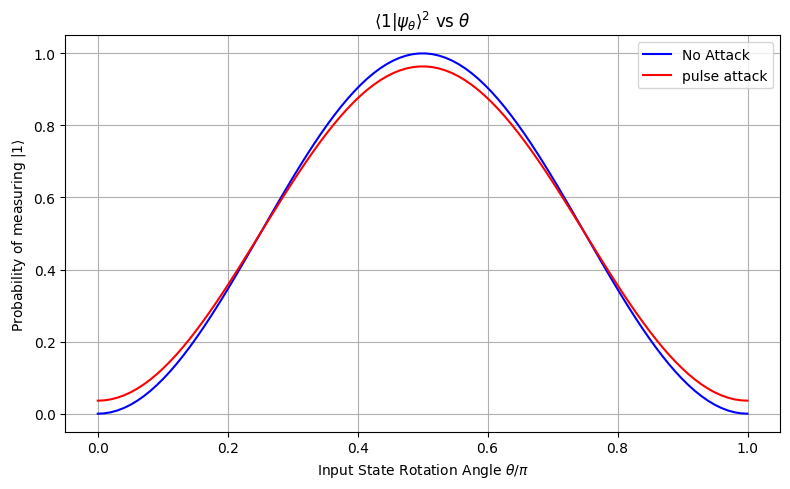

In [10]:
probs_eve = measure_with_eve(theta_vals,
                             J12=0.2,
                             J01=0.1,
                             A=(1.0, 0.5),
                             delta=(0.0, 0.0),
                             coup_12=(qt.sigmaz(), qt.sigmax()),
                             coup_01=(qt.sigmax(), qt.sigmay()))

plotting(theta_vals, probs_eve, theory)

#Finding Dominant Crosstalk Terms

In [11]:
def scan_coupling_and_pulse_effects(theta_vals, pulse_shapes, J12=0.2, J01=0.1, A=(1.0, 1.0), delta=(0.0, 0.0)):
    paulis = {'I': qt.qeye(2), 'X': qt.sigmax(), 'Y': qt.sigmay(), 'Z': qt.sigmaz()}
    results = []

    for k1, k2 in product(paulis.keys(), repeat=2):
        coup_01 = (paulis[k1], paulis[k2])
        for shape in pulse_shapes:
            # Only q1 is attacked: zero amplitude for q0
            probs_q1_only = measure_with_eve(
                theta_vals, J12=J12, J01=J01, A=(0.0, A[1]),
                delta=delta, coup_01=coup_01,
                shape=(shape, shape),
                extra_params=({}, {})
            )

            # Both q0 and q1 are attacked
            probs_q0_q1 = measure_with_eve(
                theta_vals, J12=J12, J01=J01, A=A,
                delta=delta, coup_01=coup_01,
                shape=(shape, shape),
                extra_params=({}, {})
            )

            diff_norm = np.linalg.norm(np.array(probs_q0_q1) - np.array(probs_q1_only))
            results.append((f"{k1}⊗{k2}", shape, diff_norm))

    return pd.DataFrame(results, columns=["Coupling Type (q0⊗q1)", "Pulse Shape", "||Δ|| (Influence)"]).sort_values(
        by="||Δ|| (Influence)", ascending=False).reset_index(drop=True)


In [12]:
J12=0.2
J01=0.1
pulse_shapes = ["cos", "square", "gaussian", "chirp", "drag"]

df_pulse_coupling = scan_coupling_and_pulse_effects(theta_vals, pulse_shapes, J12, J01)
print(df_pulse_coupling.head(10)) #top 10

  Coupling Type (q0⊗q1) Pulse Shape  ||Δ|| (Influence)
0                   Y⊗X       chirp           0.010840
1                   Y⊗X         cos           0.010840
2                   Z⊗X       chirp           0.007278
3                   Z⊗X         cos           0.007278
4                   Y⊗X      square           0.003672
5                   Y⊗X        drag           0.002667
6                   Y⊗X    gaussian           0.001610
7                   Z⊗X        drag           0.001380
8                   Z⊗X      square           0.001221
9                   Z⊗X    gaussian           0.000353


# Quantum Process Tomography

In [13]:
def prepare_input_states():
    return [
        qt.basis(2, 0),  # |0⟩
        qt.basis(2, 1),  # |1⟩
        (qt.basis(2, 0) + qt.basis(2, 1)).unit(),  # |+⟩
        (qt.basis(2, 0) + 1j * qt.basis(2, 1)).unit()  # |+i⟩
    ]

In [14]:
def apply_eve_process_on_q2(input_state,
                            J12=0.1, J01=0.1,
                            A=(1.0, 1.0),
                            delta=(0.0, 0.0),
                            coup_12=(qt.sigmaz(), qt.sigmax()),
                            coup_01=(qt.sigmax(), qt.sigmax()),
                            shape=("cos", "cos"),
                            extra_params=({}, {})):
    full_state = qt.tensor(qt.basis(2, 0), qt.basis(2, 0), input_state)
    final_state = apply_eve_multi_attack(
        state_pre=full_state,
        J12=J12,
        J01=J01,
        A=A,
        delta=delta,
        coup_12=coup_12,
        coup_01=coup_01,
        shape=shape,
        extra_params=extra_params
    )
    return final_state.ptrace(2)

In [15]:
def perform_qpt(J12=0.2, J01=0.1, A=(1.0, 1.0), delta=(0.0, 0.0),
                coup_12=(qt.sigmaz(), qt.sigmax()), coup_01=(qt.sigmax(), qt.sigmax()),
                shape=("cos", "cos"), extra_params=({}, {})):

    paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    labels = ["I", "X", "Y", "Z"]
    N = len(paulis)
    chi = np.zeros((N, N), dtype=complex)

    input_states = prepare_input_states()
    output_states = [
        apply_eve_process_on_q2(psi,
                                J12=J12, J01=J01, A=A,
                                delta=delta,
                                coup_12=coup_12, coup_01=coup_01,
                                shape=shape,
                                extra_params=extra_params)
        for psi in input_states
    ]

    for m, Em in enumerate(paulis):
        for n, En in enumerate(paulis):
            acc = 0.0
            for i, psi_in in enumerate(input_states):
                rho_in = psi_in * psi_in.dag()
                term = (Em * rho_in * En.dag())
                acc += (term * output_states[i]).tr()
            chi[m, n] = acc / 2.0  # normalization

    return qt.Qobj(chi), labels


In [16]:
def plot_chi_matrix(chi_matrix, title='Chi Matrix'):
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.matshow(np.abs(chi_matrix), cmap='viridis')
    fig.colorbar(cax)
    ax.set_xticks(range(4))
    ax.set_yticks(range(4))
    ax.set_xticklabels(pauli_labels)
    ax.set_yticklabels(pauli_labels)
    plt.title(title)
    plt.xlabel('n')
    plt.ylabel('m')
    plt.tight_layout()
    plt.show()

In [17]:
chi, label = perform_qpt(
    J12=0.2,
    J01=0.1,
    A=(1.0, 0.5),
    delta=(0.0, 0.0),
    coup_12=(qt.sigmaz(), qt.sigmax()),
    coup_01=(qt.sigmay(), qt.sigmax()),
    shape=("cos", "chirp"),
    extra_params=({}, {"chirp_rate": 5.0})
)

from qiskit.visualization import array_to_latex as show
show(chi.full())

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


<IPython.core.display.Latex object>

In [18]:
# Extract Kraus operators from the chi matrix
def kraus_operators_from_chi(chi):
    eigvals, eigvecs = np.linalg.eigh(chi)
    kraus_ops = []
    for i in range(len(eigvals)):
        if np.abs(eigvals[i]) > 1e-6:
            kraus_matrix = sum(
                eigvecs[j, i] * paulis[j] for j in range(4)
            )
            kraus_ops.append(np.sqrt(eigvals[i]) * kraus_matrix)
    return kraus_ops

In [19]:
kraus_ops = kraus_operators_from_chi(chi.full())
for i, K in enumerate(kraus_ops):
    print(f"Kraus Operator {i + 1}:")
    display(show(K.full()))

Kraus Operator 1:


<IPython.core.display.Latex object>

Kraus Operator 2:


<IPython.core.display.Latex object>

Kraus Operator 3:


<IPython.core.display.Latex object>

Kraus Operator 4:


<IPython.core.display.Latex object>

#Choi

In [20]:
def chi_to_superop(chi):
    superop = 0
    for m, Em in enumerate(paulis):
        for n, En in enumerate(paulis):
            kron = qt.tensor(Em, En.conj())
            superop += chi[m, n] * kron
    return Qobj(superop)

chi_identity = np.zeros((4, 4), dtype=complex)
chi_identity[0, 0] = 1.0  # Identity channel

#K=U.P (polar decomposition)

Unitary approximation of dominant Kraus op:
[[ 0.084+0.173j  0.882-0.43j ]
 [ 0.426+0.884j -0.173+0.083j]]


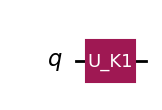

In [21]:
K1 = kraus_ops[0].full()

U, P = polar(K1)

# Approximate as unitary
U_qiskit = Operator(U)
qc = QuantumCircuit(1)
qc.unitary(U_qiskit, 0, label="U_K1")

print("Unitary approximation of dominant Kraus op:")
print(np.round(U, 3))

qc.draw("mpl")

In [22]:
unitaries = []
circuits = []

for i, K in enumerate(kraus_ops):
    print(f"\n=== Kraus Operator {i+1} ===")
    K_mat = K.full()

    # Polar decomposition: K = U * P
    U, P = polar(K_mat)
    unitaries.append(U)

    print("Approximate Unitary U:")
    display(show(np.round(U, 3)))

    U_qiskit = Operator(U)
    qc = QuantumCircuit(1, name=f"U_{i+1}")
    qc.unitary(U_qiskit, 0)
    circuits.append(qc)


=== Kraus Operator 1 ===
Approximate Unitary U:


<IPython.core.display.Latex object>


=== Kraus Operator 2 ===
Approximate Unitary U:


<IPython.core.display.Latex object>


=== Kraus Operator 3 ===
Approximate Unitary U:


<IPython.core.display.Latex object>


=== Kraus Operator 4 ===
Approximate Unitary U:


<IPython.core.display.Latex object>

#Fitting Circuit

In [24]:
weights = []
angles = []

for K in kraus_ops:
    Kmat = K.full()
    w = np.trace(Kmat.conj().T @ Kmat).real
    weights.append(w)

    U, P = polar(Kmat)
    # For a unitary, U = exp(-i*theta*n·σ/2)
    # For RY(θ): U[0,0]=cos(θ/2), U[1,0]=sin(θ/2)
    theta = 2 * np.arccos(U[0, 0].real)
    angles.append(theta)

# Normalize weights
weights = np.array(weights)
weights /= weights.sum()

# Weighted average θ
theta_weighted = np.sum(weights * angles)
print("Weighted average θ:", theta_weighted)

Weighted average θ: 4.986295930985632


In [26]:
def simulate_chi_for_theta(theta, J12=0.2, J01=0.1, A=(1.0, 0.5),
                           delta=(0.0, 0.0),
                           coup_12=(qt.sigmaz(), qt.sigmax()),
                           coup_01=(qt.sigmay(), qt.sigmax()),
                           shape=("cos", "chirp"),
                           extra_params=({}, {"chirp_rate": 5.0})):
    def build_adam_state_theta(theta):
        psi_theta = (np.cos(theta) * qt.basis(2, 0) + np.sin(theta) * qt.basis(2, 1)).unit()
        zero = qt.basis(2, 0)
        return qt.tensor(zero, zero, psi_theta)

    chi, labels = perform_qpt(
        J12=J12, J01=J01, A=A, delta=delta,
        coup_12=coup_12, coup_01=coup_01,
        shape=shape, extra_params=extra_params
    )
    return chi.full()

In [27]:
def cost_fn(theta, chi_target):
    chi_sim = simulate_chi_for_theta(
        theta,)
    # Frobenius norm of difference
    return np.linalg.norm(chi_sim - chi_target)

In [28]:
theta0 = theta_weighted

res = minimize(
    cost_fn,
    x0=[theta0],
    args=(chi.full(),),
    bounds=[(0, 2 * np.pi)],
    method='L-BFGS-B'
)

theta_opt = res.x[0]
print(f"Optimal θ: {theta_opt:.6f} rad")
print(f"Fitting loss: {res.fun:.6e}")

Optimal θ: 4.986296 rad
Fitting loss: 0.000000e+00


/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


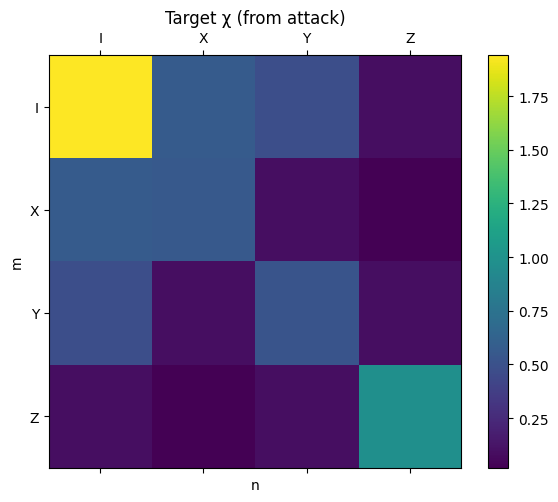

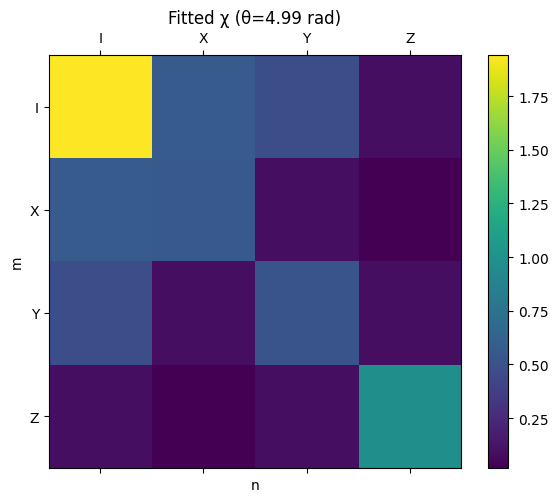

In [29]:
chi_fit = simulate_chi_for_theta(theta_opt)

plot_chi_matrix(chi.full(), title="Target χ (from attack)")
plot_chi_matrix(chi_fit, title=f"Fitted χ (θ={theta_opt:.2f} rad)")